In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-5nwbc_n6
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-5nwbc_n6
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275364 sha256=a04ff6bcdeddb9601848616e52f6bdec52a37fd0384d53abf2caa86f2e84871e
  Stored in directory: /tmp/pip-ephem-wheel-cache-j12kqez3/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software F

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


In [0]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

### Run a pre-trained detectron2 model

--2020-03-30 01:36:19--  https://lsco.scene7.com/is/image/lsco/levis/clothing/748790000-back-pdp.jpg
Resolving lsco.scene7.com (lsco.scene7.com)... 23.208.78.57, 2a02:26f0:7b:990::9b6, 2a02:26f0:7b:991::9b6
Connecting to lsco.scene7.com (lsco.scene7.com)|23.208.78.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195340 (191K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 190.76K  --.-KB/s    in 0.01s   

2020-03-30 01:36:19 (13.8 MB/s) - ‘input.jpg’ saved [195340/195340]



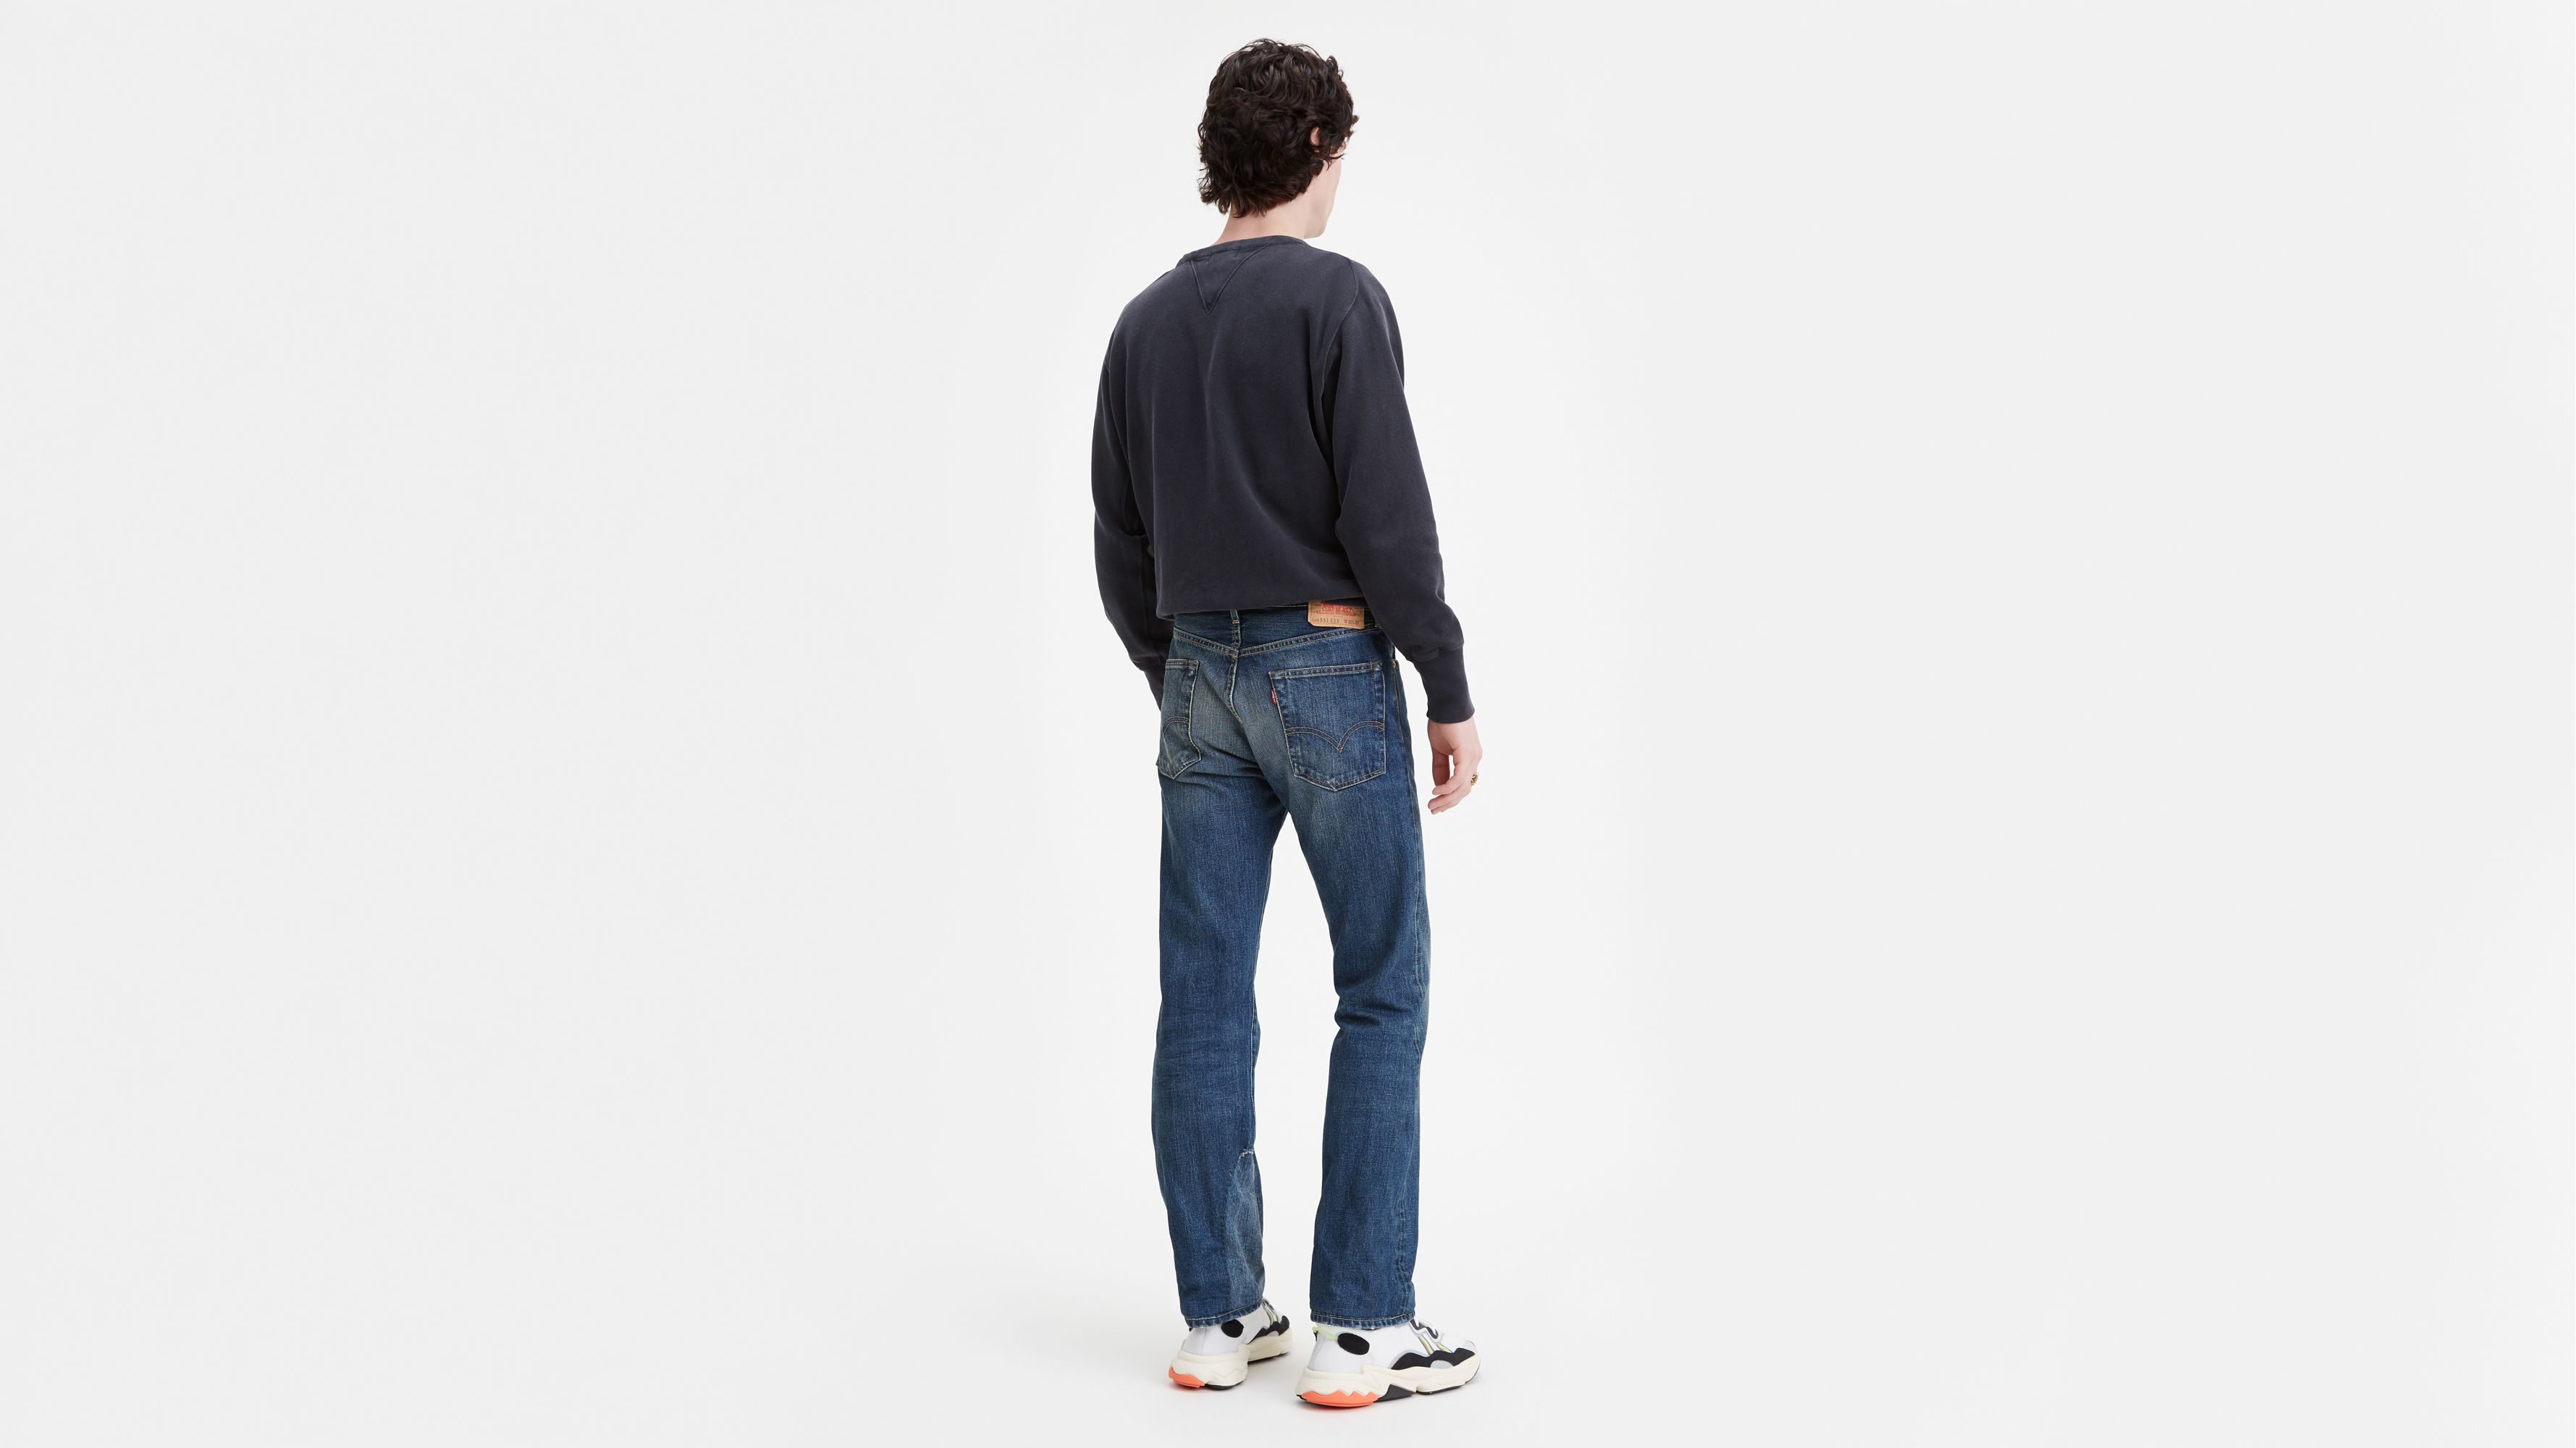

In [0]:
!wget https://lsco.scene7.com/is/image/lsco/levis/clothing/748790000-back-pdp.jpg -O input.jpg


im = cv2.imread("./input.jpg")
cv2_imshow(im)

### Create a detctron2 confid and use the `DefaultPredictor` to run inference on this image

In [0]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [0]:
# https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
outputs["instances"].pred_boxes

Boxes(tensor([[1494.4282,   65.0596, 2062.5750, 1935.2487]], device='cuda:0'))

In [0]:
outputs["instances"].pred_classes

tensor([0], device='cuda:0')

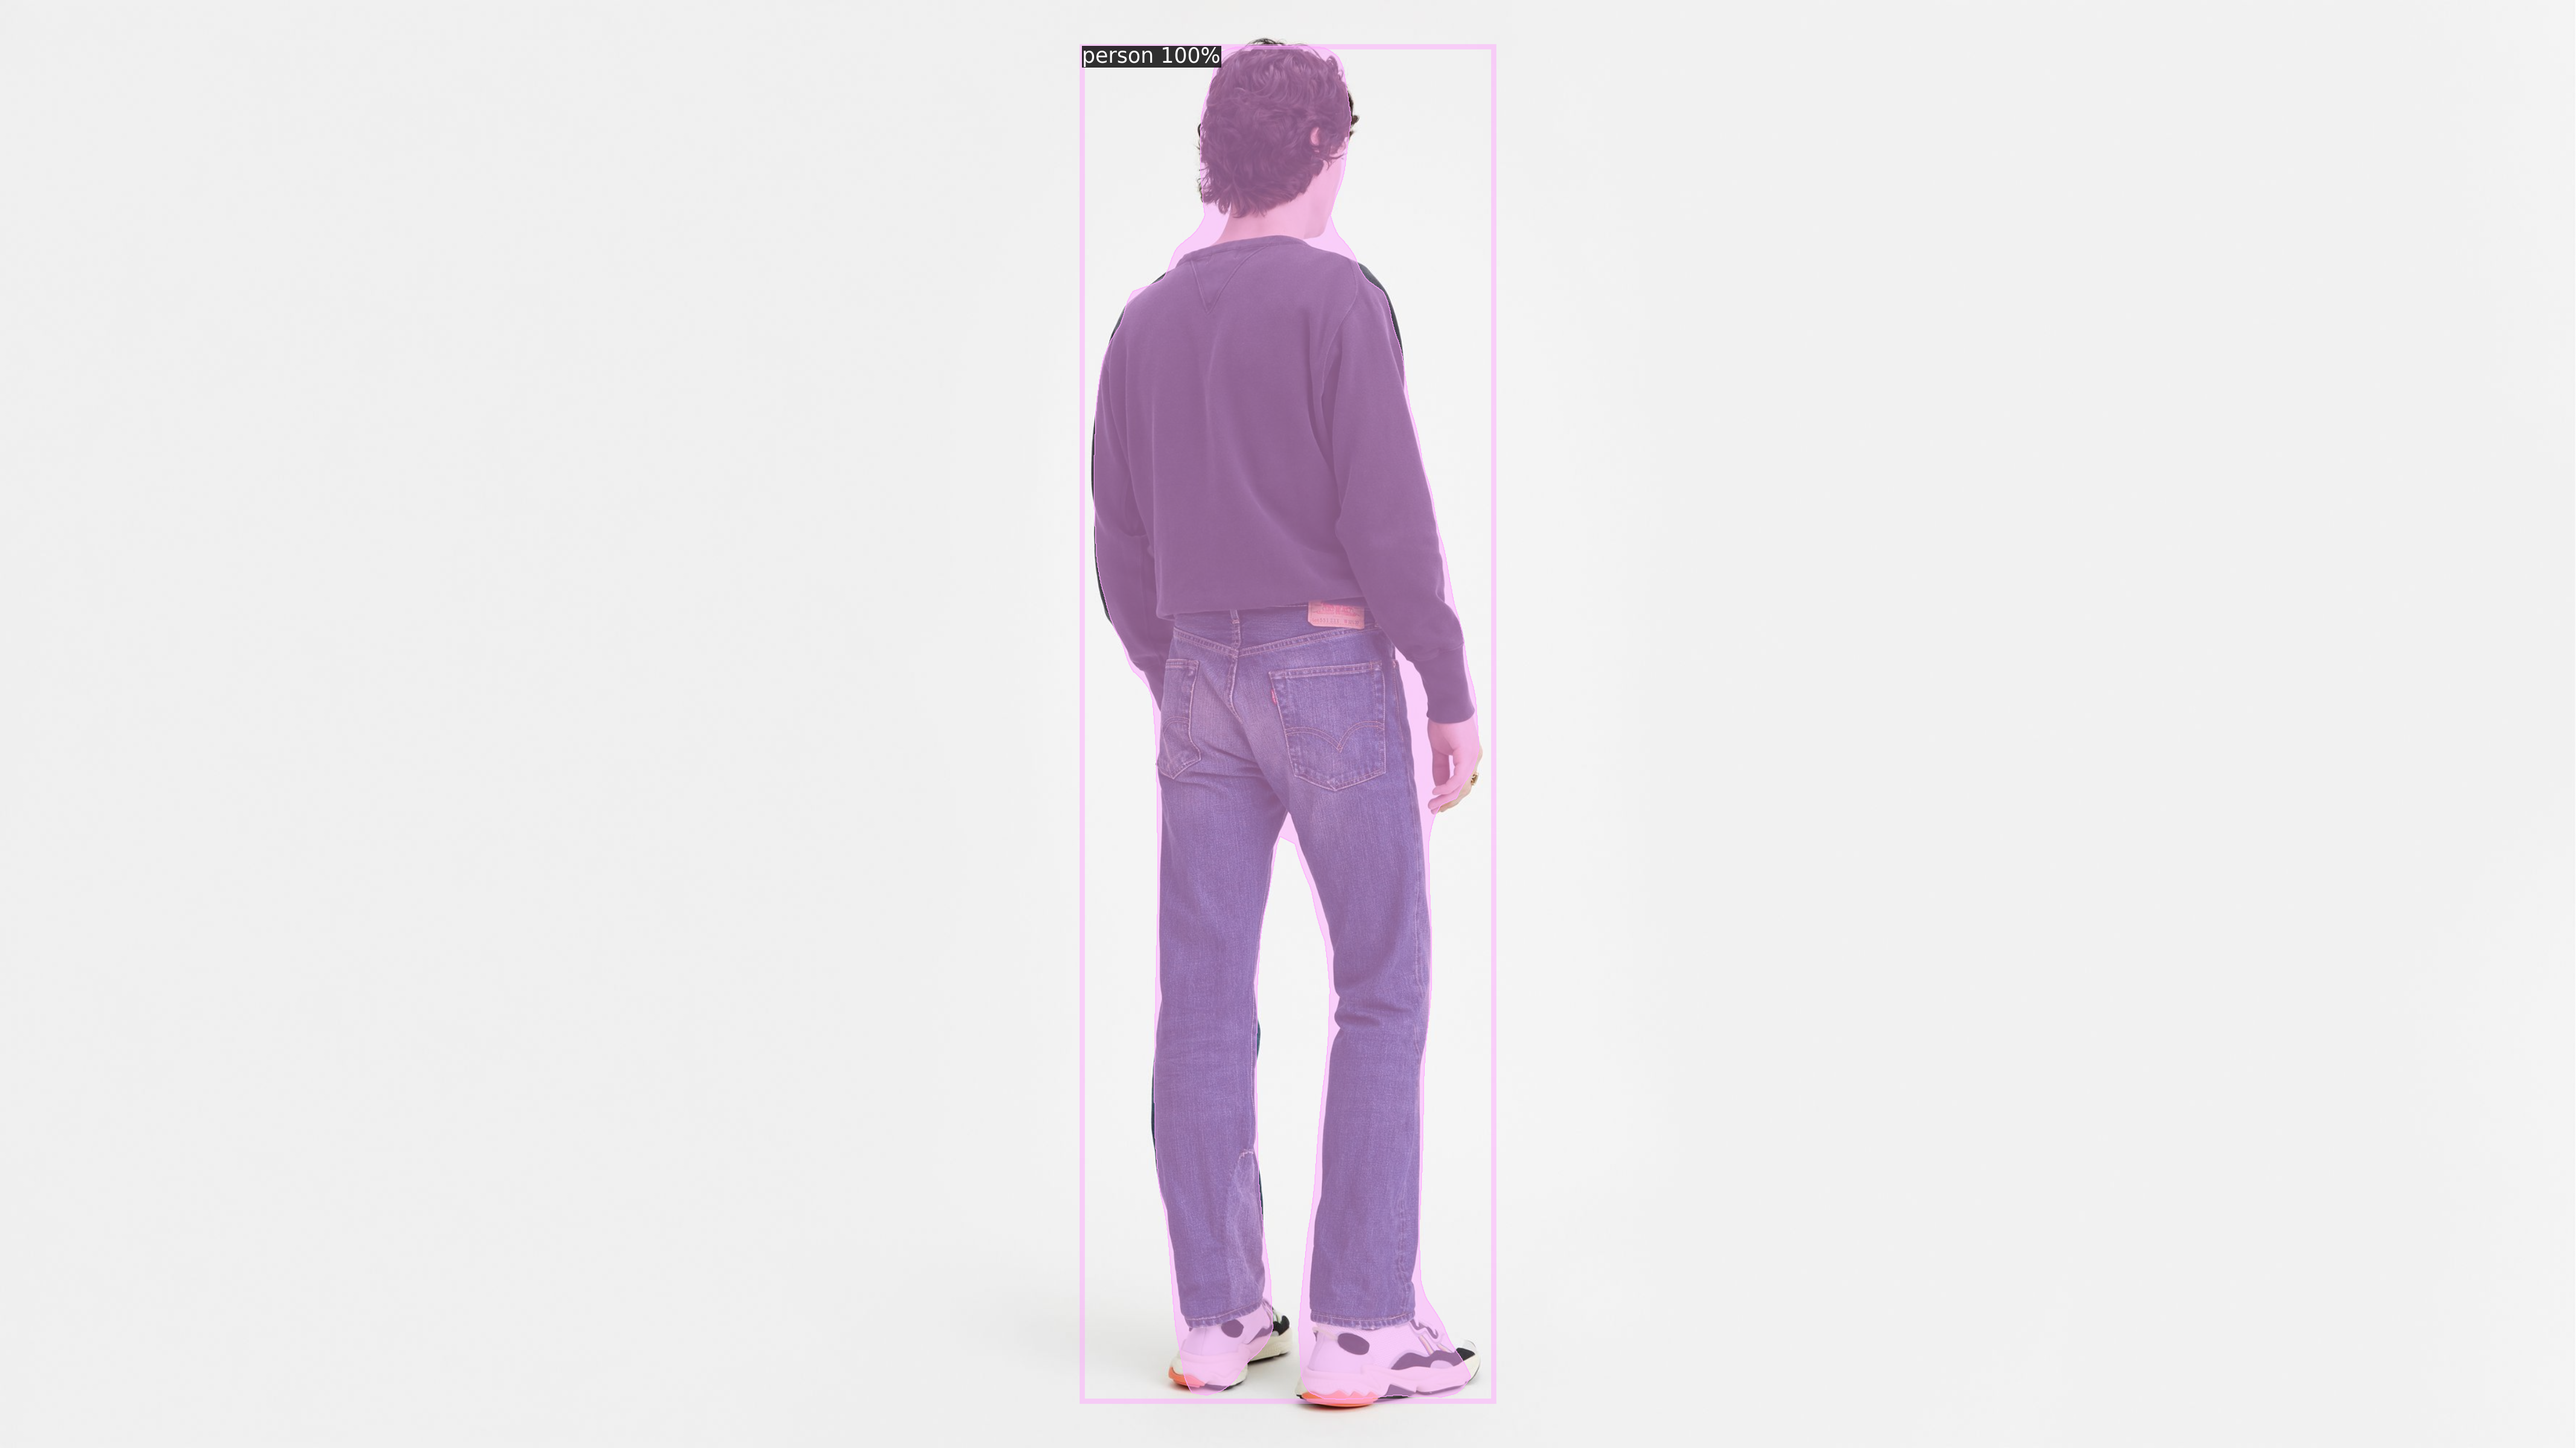

In [0]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

### Train on Levis Jeans Dataset
- Levis Segmentation Dataste is created
- Use the pre-trained model on COCO dataset from Model Zoo
- `Jeans` is the new class 

### Prepare the Jeans Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'Levis/'

Mounted at /content/drive


In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_jeans_dicts(img_dir, json_file_name):
  json_file = os.path.join(img_dir,json_file_name)
  with open(json_file) as f:
      imgs_meta = json.load(f)
    
  imgs_anns = imgs_meta['_via_img_metadata']

  dataset_dicts = []
  for idx, v in enumerate(imgs_anns.values()):
      record = {}
        
      filename = os.path.join(img_dir, v["filename"])
      height, width = cv2.imread(filename).shape[:2]
        
      record["file_name"] = filename
      record["image_id"] = idx
      record["height"] = height
      record["width"] = width
      
      annos = v["regions"]
      objs = []
      #print(idx)
      #print(filename)

      try:

        px = annos[0]['shape_attributes']['all_points_x']
        py = annos[0]['shape_attributes']['all_points_y']
      
    
        #print('px,py', px,py)
    
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]
        #print('ploy',poly)
        #print('endo of one record')
        obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
        objs.append(obj)

      
        record["annotations"] = objs
        dataset_dicts.append(record)
      except:
        print(filename,'has not right data, delete from dataset')
  return dataset_dicts




In [0]:
img_dir = base_dir + 'jeans/'
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("jeans_" + d, lambda d=d: get_jeans_dicts(img_dir + d,'jeans_train.json'))
    MetadataCatalog.get("jeans_" + d).set(thing_classes=["jeans"])
jeans_metadata = MetadataCatalog.get("jeans_train")

In [0]:
dataset_dicts = get_jeans_dicts(img_dir+'train','jeans_train.json')


/content/drive/My Drive/Levis/jeans/train/005012940___005012940-back-pdp.jpg has not right data, delete from dataset


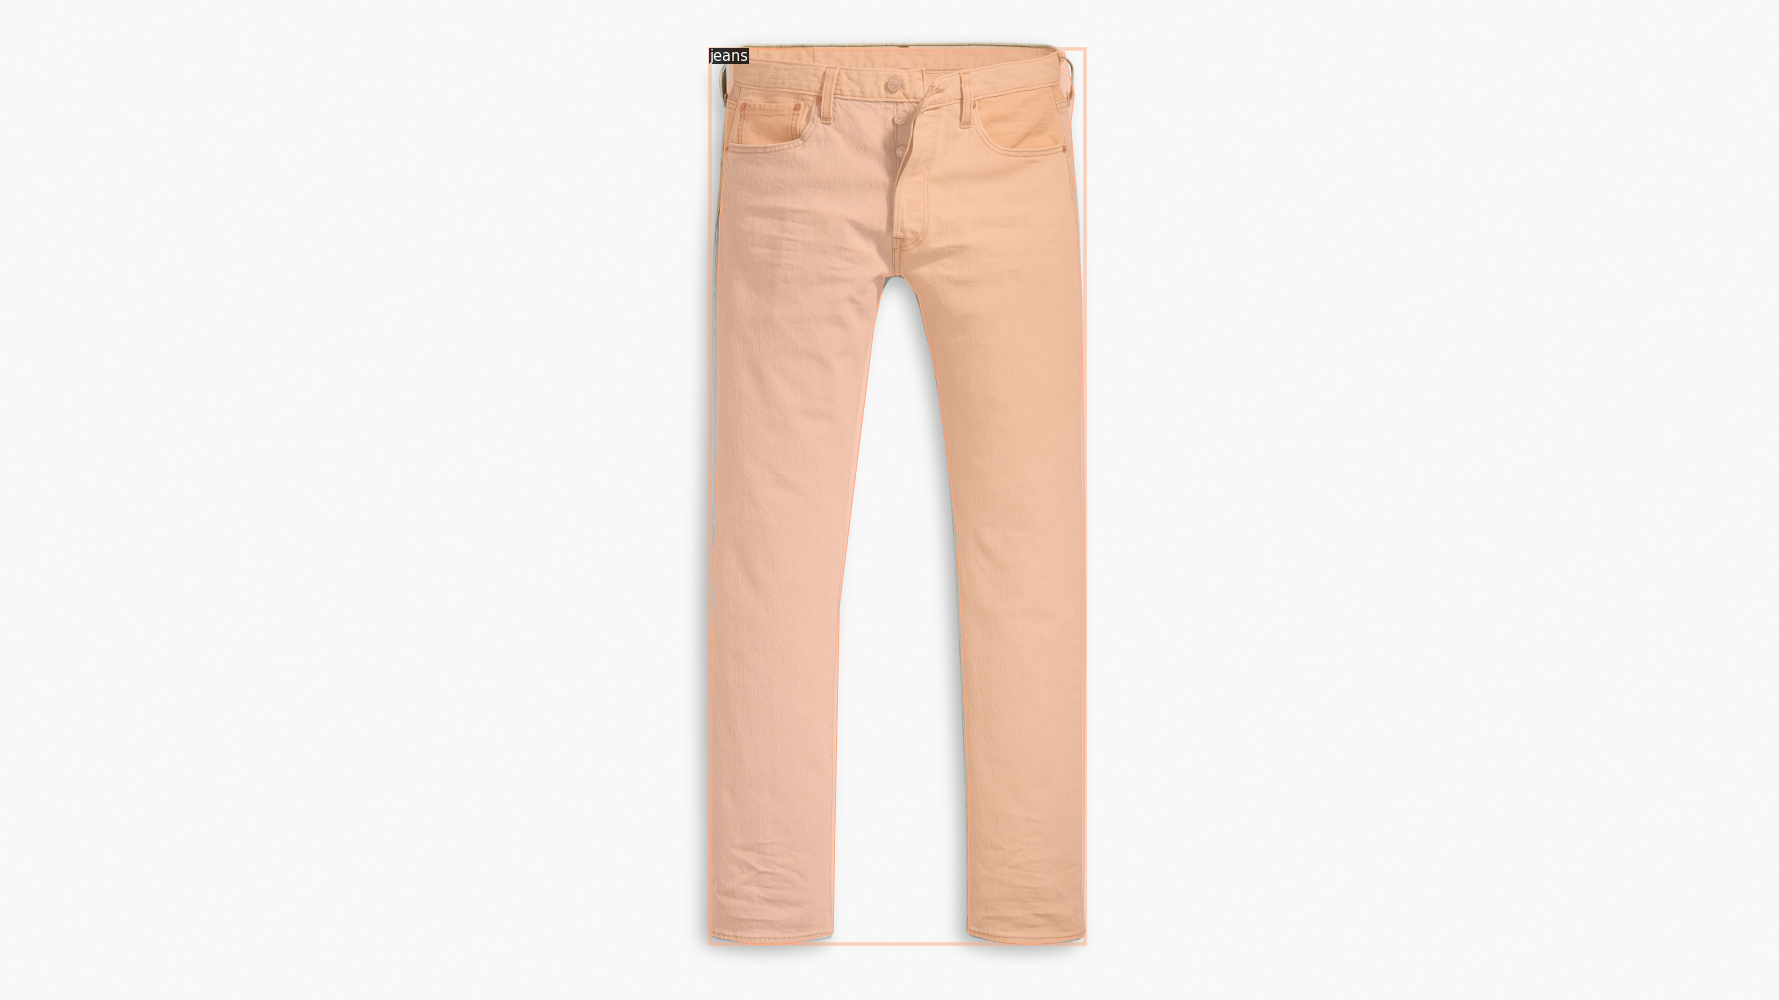

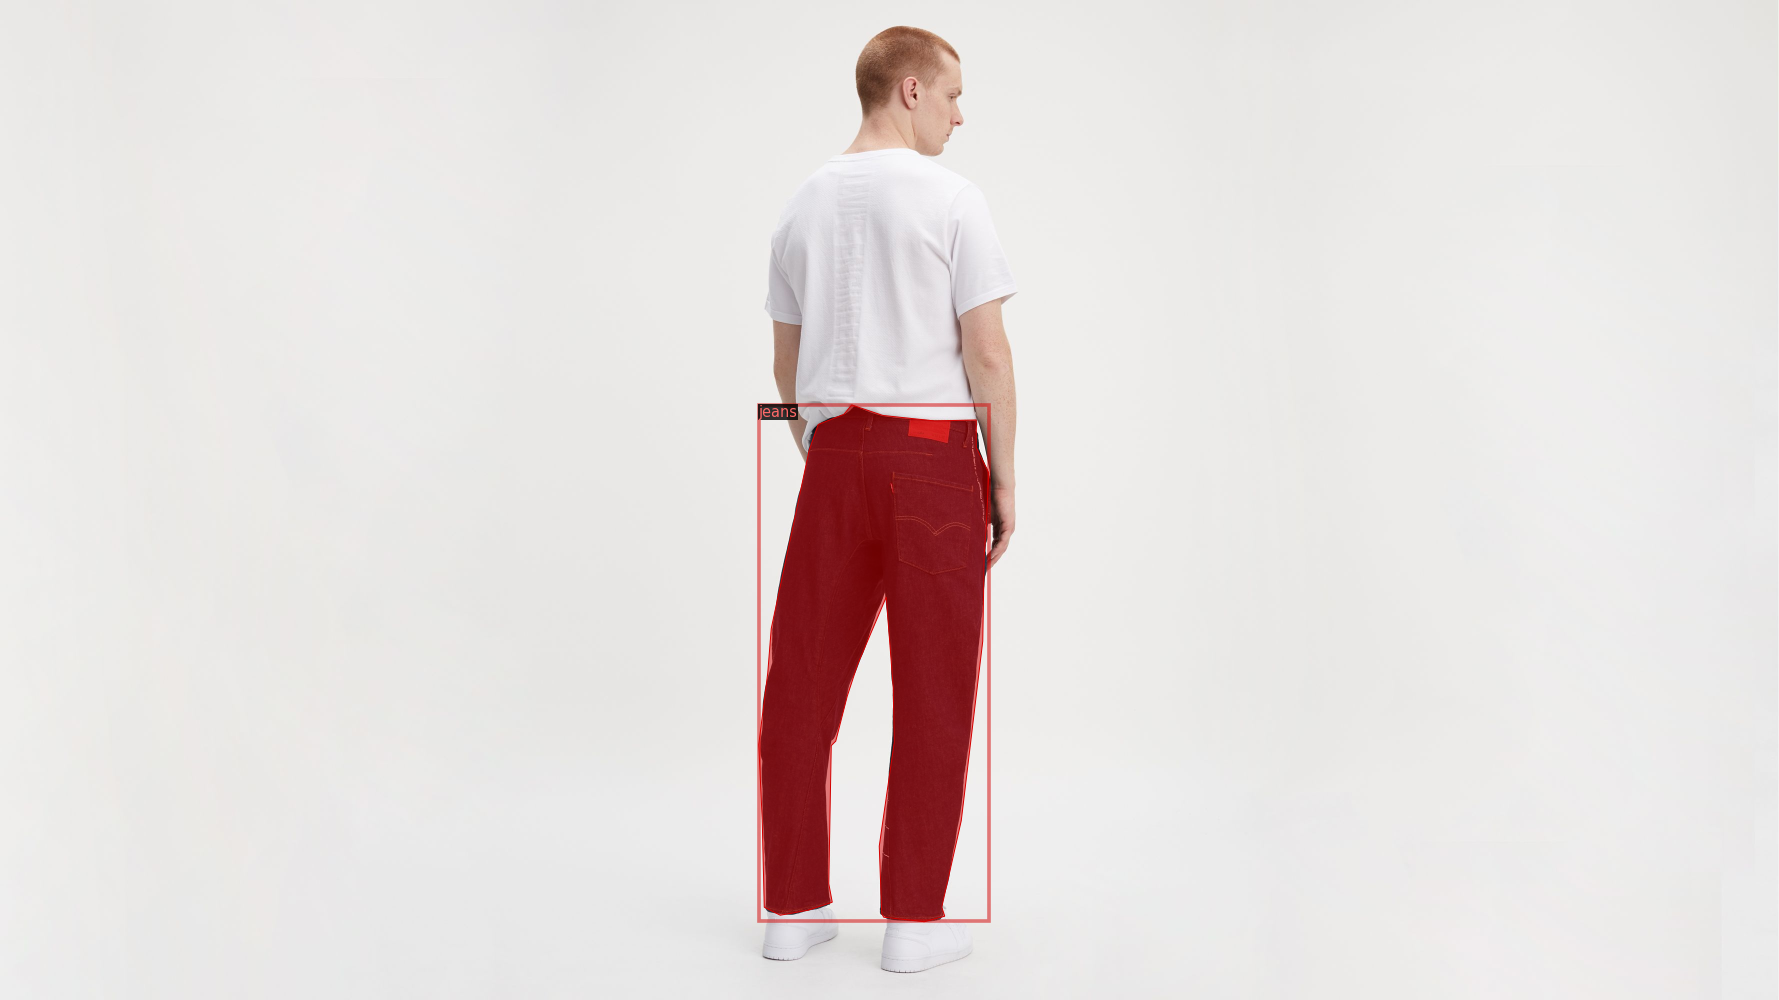

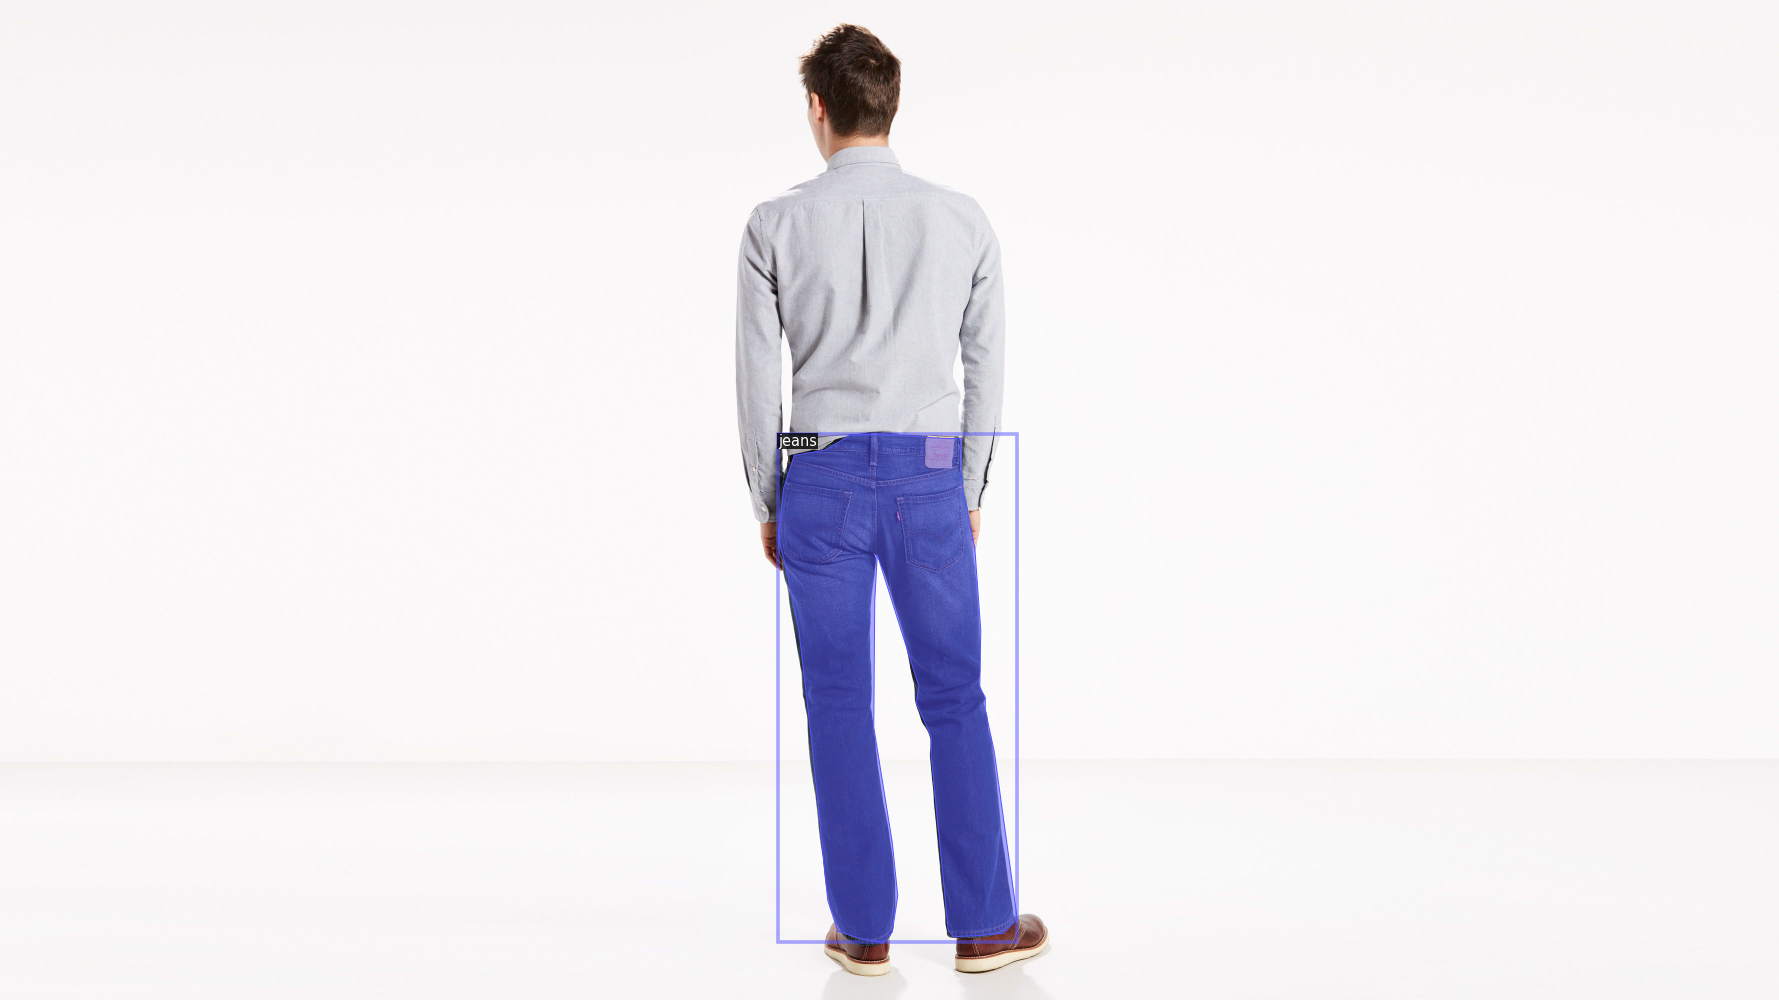

In [0]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=jeans_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


### Train the Jean Dataset

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("jeans_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02  # 0.00025
cfg.SOLVER.MAX_ITER = 300    #  may need to train longer for bigger dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class "Jeans"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/30 01:37:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[03/30 01:37:42 d2.engine.train_loop]: Starting training from iteration 0
[03/30 01:37:56 d2.utils.events]:  eta: 0:03:06  iter: 19  total_loss: 1.547  loss_cls: 0.363  loss_box_reg: 0.343  loss_mask: 0.668  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6459  data_time: 0.3166  lr: 0.000400  max_mem: 2847M
[03/30 01:38:09 d2.utils.events]:  eta: 0:02:44  iter: 39  total_loss: 1.007  loss_cls: 0.155  loss_box_reg: 0.398  loss_mask: 0.469  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  time: 0.6368  data_time: 0.2637  lr: 0.000799  max_mem: 2847M
[03/30 01:38:22 d2.utils.events]:  eta: 0:02:36  iter: 59  total_loss: 0.766  loss_cls: 0.093  loss_box_reg: 0.451  loss_mask: 0.165  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  time: 0.6435  data_time: 0.2890  lr: 0.001199  max_mem: 2847M
[03/30 01:38:35 d2.utils.events]:  eta: 0:02:22  iter: 79  total_loss: 0.579  loss_cls: 0.059  loss_box_reg: 0.382  loss_mask: 0.111  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6454  data_time: 0.2782  lr:

In [0]:
!nvidia-smi
# Look at training curves in tensorboard:
#%load_ext tensorboard
#%tensorboard --logdir output

Mon Mar 30 01:40:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    29W /  70W |   5025MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85   # set the testing threshold for this model
cfg.DATASETS.TEST = ("jeans_val", )
predictor = DefaultPredictor(cfg)

### Inference & evaluation using the trained model

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_jeans_dicts(img_dir+'val','jeans_val.json')
for d in random.sample(dataset_dicts, 6):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=jeans_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Inference with a keypoint detection model
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

--2020-03-30 01:41:21--  https://lsco.scene7.com/is/image/lsco/levis/clothing/748790000-back-pdp.jpg
Resolving lsco.scene7.com (lsco.scene7.com)... 23.208.78.57, 2a02:26f0:7b:991::9b6, 2a02:26f0:7b:990::9b6
Connecting to lsco.scene7.com (lsco.scene7.com)|23.208.78.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195340 (191K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 190.76K  --.-KB/s    in 0.01s   

2020-03-30 01:41:21 (14.2 MB/s) - ‘input.jpg’ saved [195340/195340]



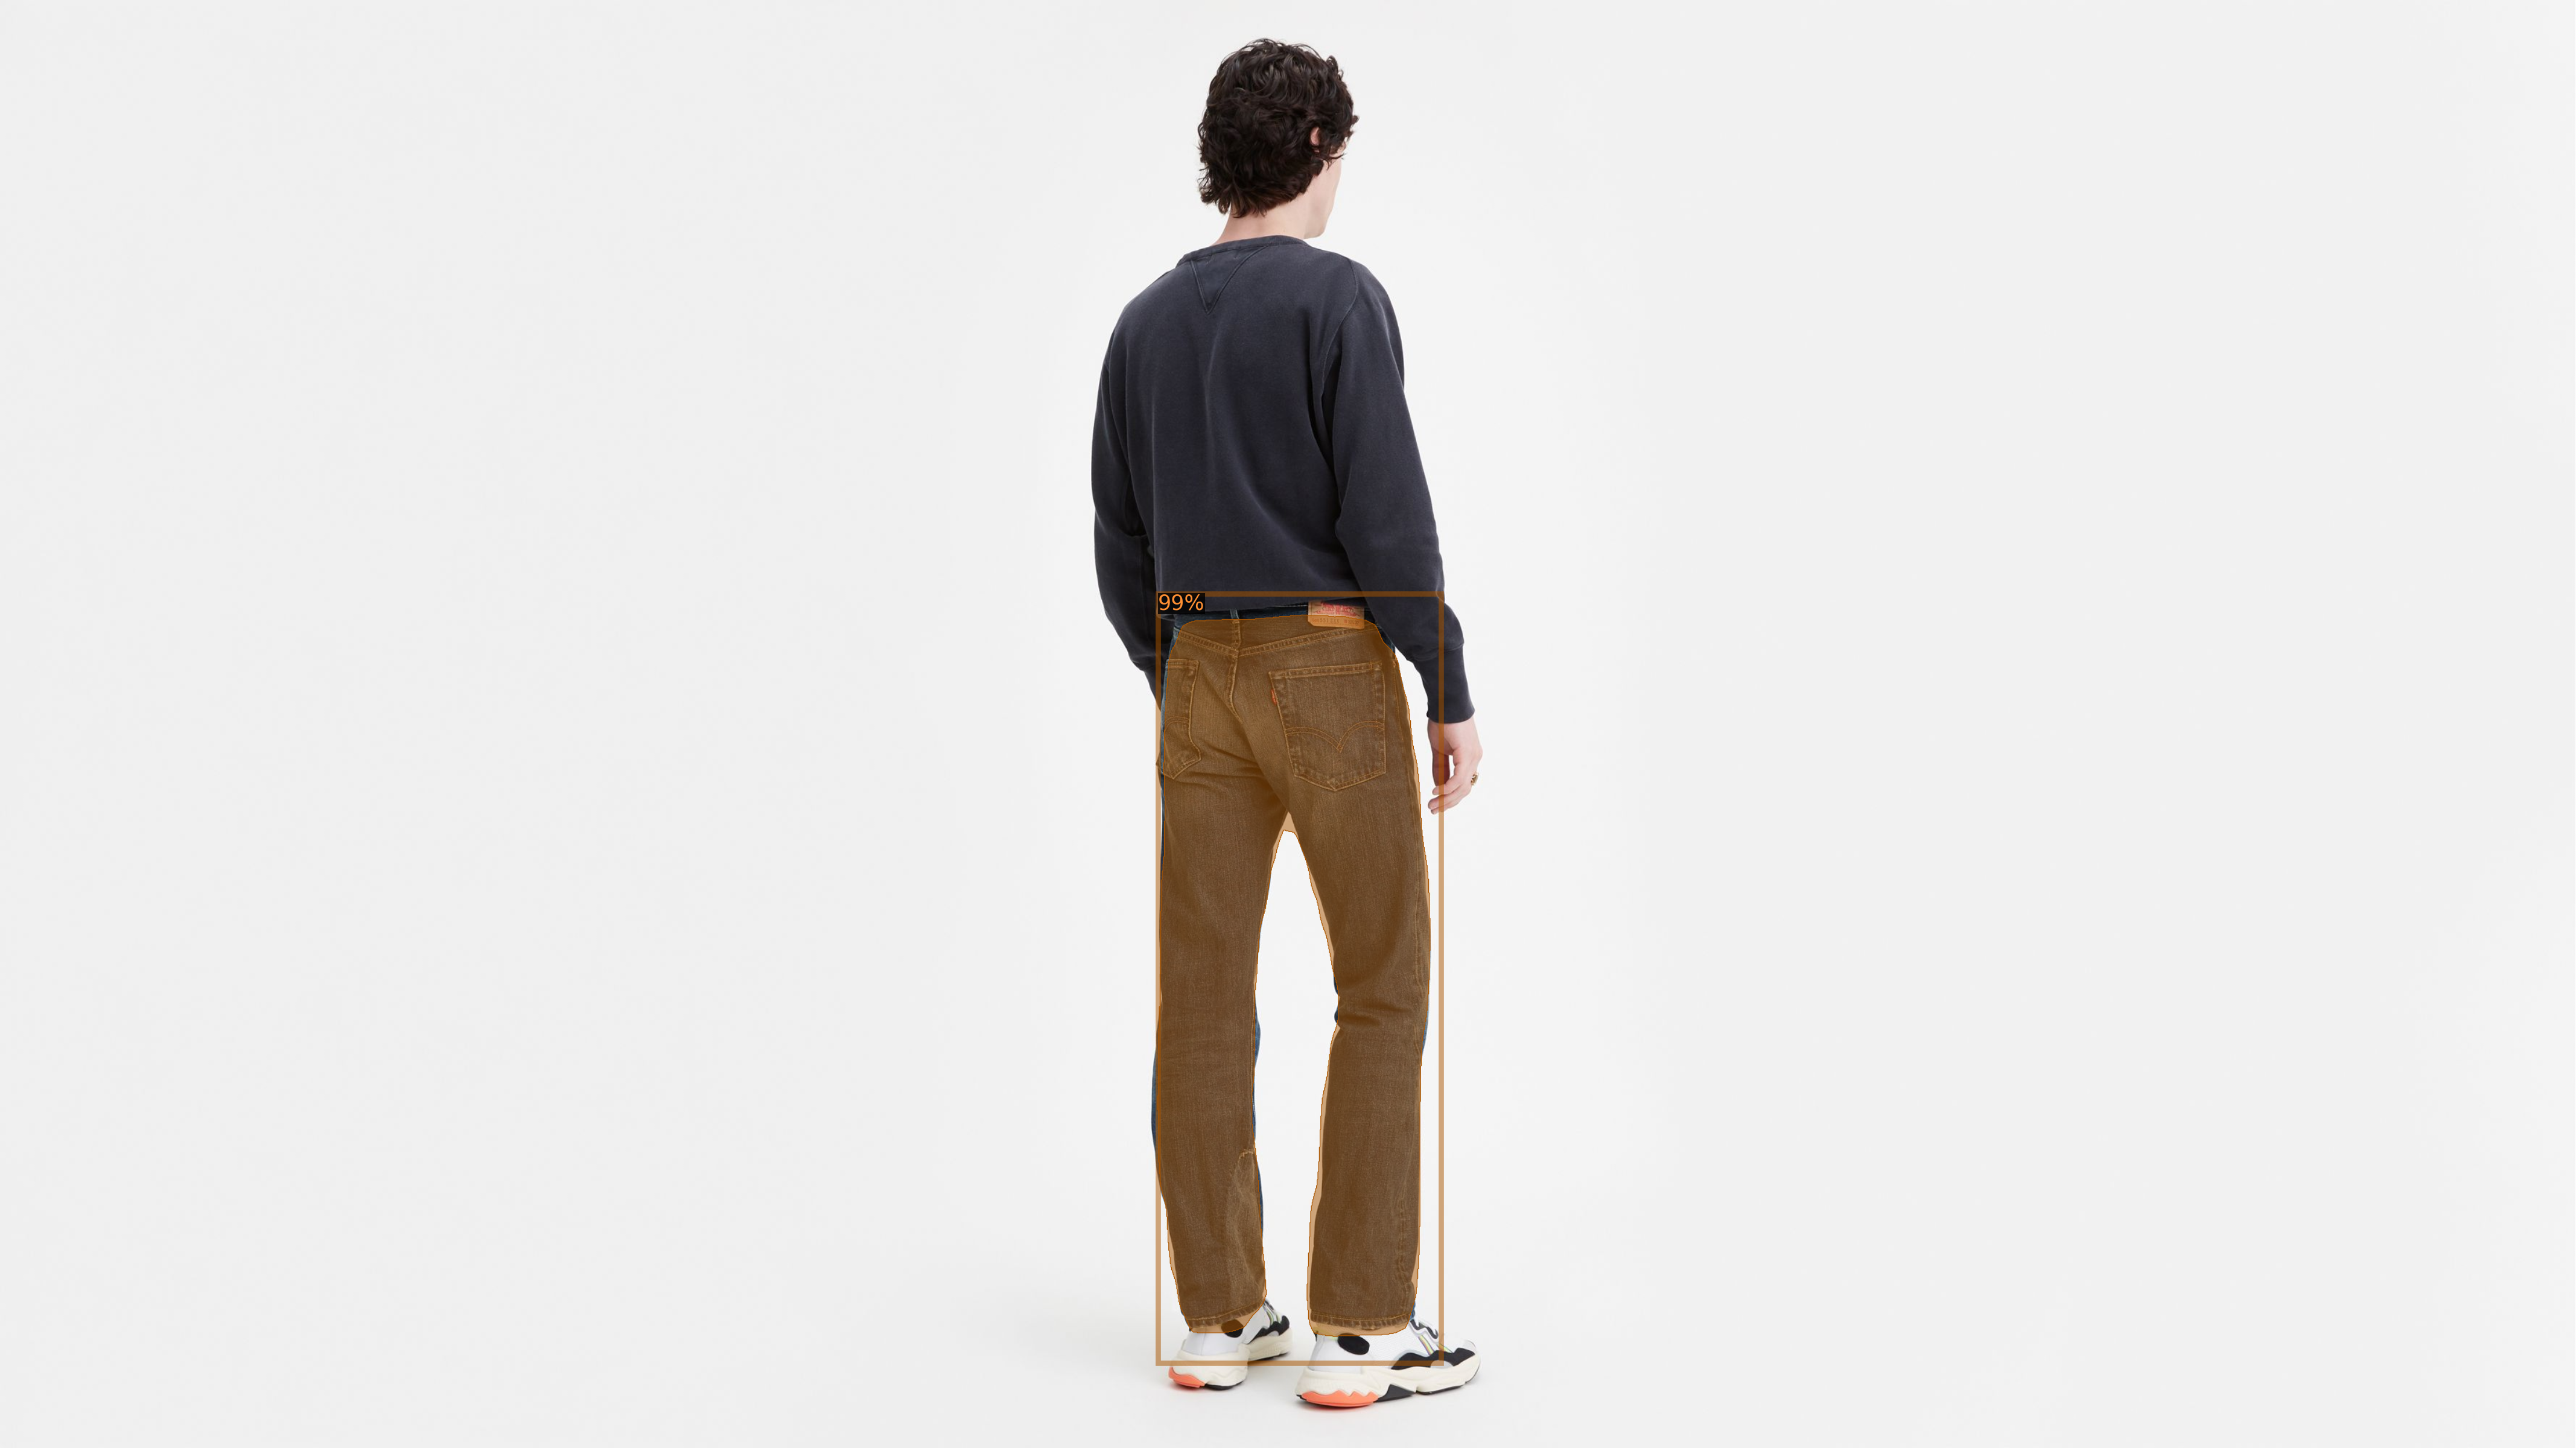

In [0]:
!wget https://lsco.scene7.com/is/image/lsco/levis/clothing/748790000-back-pdp.jpg -O input.jpg


im = cv2.imread("./input.jpg")

outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

### Test Cases

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.80   # set the testing threshold for this model
cfg.DATASETS.TEST = ("jeans_val", )
predictor = DefaultPredictor(cfg)

In [0]:
import glob

test_fn = glob.glob(img_dir +'test/*.*')
for fn in test_fn:
  im = cv2.imread(fn)
  height, _ = cv2.imread(fn).shape[:2]
  if height > 1024:
    scale_factor = int(height/1024)
    scale = round(0.4/scale_factor,1)
  else:
    scale_factor = int(1024/height)
    scale = round(0.4*scale_factor, 1)
  
  outputs = predictor(im)
  v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(v.get_image()[:, :, ::-1]) 

Output hidden; open in https://colab.research.google.com to view.